In [6]:
# compute length of phasing blocks

import numpy as np

def readHapMap(path2Map):
    # assume the first row is header, so we ignore it
    bps = []
    cMs = []
    with open(path2Map) as f:
        f.readline()
        line = f.readline()
        while line:
            _, bp, _, cM = line.strip().split()
            bps.append(int(bp))
            cMs.append(float(cM))
            line = f.readline()
    return np.array(bps), np.array(cMs)


def bp2cM(bp, bps, cMs):
    # bps: a list of basepair position
    # cMs: a list of geneticMap position in cM corresponding to bps
    assert(len(bps) == len(cMs))
    i = np.searchsorted(bps, bp, side='left')

    if i == 0:
        return cMs[0]*(bp/bps[0])
    elif i == len(bps):
        return cMs[-1]
    elif bps[i] == bp:
        return cMs[i]
    else:
        left_bp, right_bp = bps[i-1], bps[i]
        left_cM, right_cM = cMs[i-1], cMs[i]
        return left_cM + (right_cM - left_cM)*(bp - left_bp)/(right_bp - left_bp)

bps, cMs = readHapMap(f"/mnt/archgen/users/yilei/Data/Hapmap/genetic_map_GRCh37_chr3.txt")

def readDiffSwitchFile(path2file):
    blocks = []
    with open(path2file) as f:
        f.readline() # skip header line
        prev_end_bp = -1
        prev_end_cm = -1
        line = f.readline()
        while line:
            _, curr_start, curr_end, _ = line.strip().split()
            curr_start_bp, curr_end_bp = int(curr_start), int(curr_end)
            curr_start_cm, curr_end_cm = bp2cM(curr_start_bp, bps, cMs), bp2cM(curr_end_bp, bps, cMs)
            if prev_end_cm != -1 and curr_start_cm - prev_end_cm > 0 :
                blocks.append(curr_start_cm - prev_end_cm)
                # if curr_start_cm - prev_end_cm == 0.0:
                #     print(f'{prev_end_bp} - {curr_start_bp}')
            blocks.append(curr_end_cm - curr_start_cm)
            # if curr_end_cm - curr_start_cm == 0.0:
            #     print(f'{curr_start_bp} - {curr_end_bp}')
            prev_end_cm = curr_end_cm
            prev_end_bp = curr_end_bp
            line = f.readline()
    return blocks

def readDiffSwitchFileOneBatch(basepath, filename):
    blocks_all = []
    for r in np.arange(1,51):
        blocks = readDiffSwitchFile(f'{basepath}/batch{r}/{filename}')
        blocks_all.extend(blocks)
    return np.array(blocks_all)


In [10]:
blocks = readDiffSwitchFile('/mnt/archgen/users/yilei/IBDsim/downsample/wgs/I3949/cov1/batch3/out.diff.switch.1240k')
print(np.mean(blocks))

0.4926023711111111


cov5: 0.1129067583496758
cov2: 0.1818139254349932
cov1: 0.25661722696097755
cov3over4: 0.27067286007406605
cov1over2: 0.2710044939474506
cov1over4: 0.21992285317394
cov1over10: 0.12700687392941457
cov2: 0.18202169949681668
cov1: 0.12547936051849273
cov3over4: 0.10609218352058548
cov1over2: 0.08135991980762794
cov1over4: 0.05322539744094242
cov1over10: 0.03440176122469476


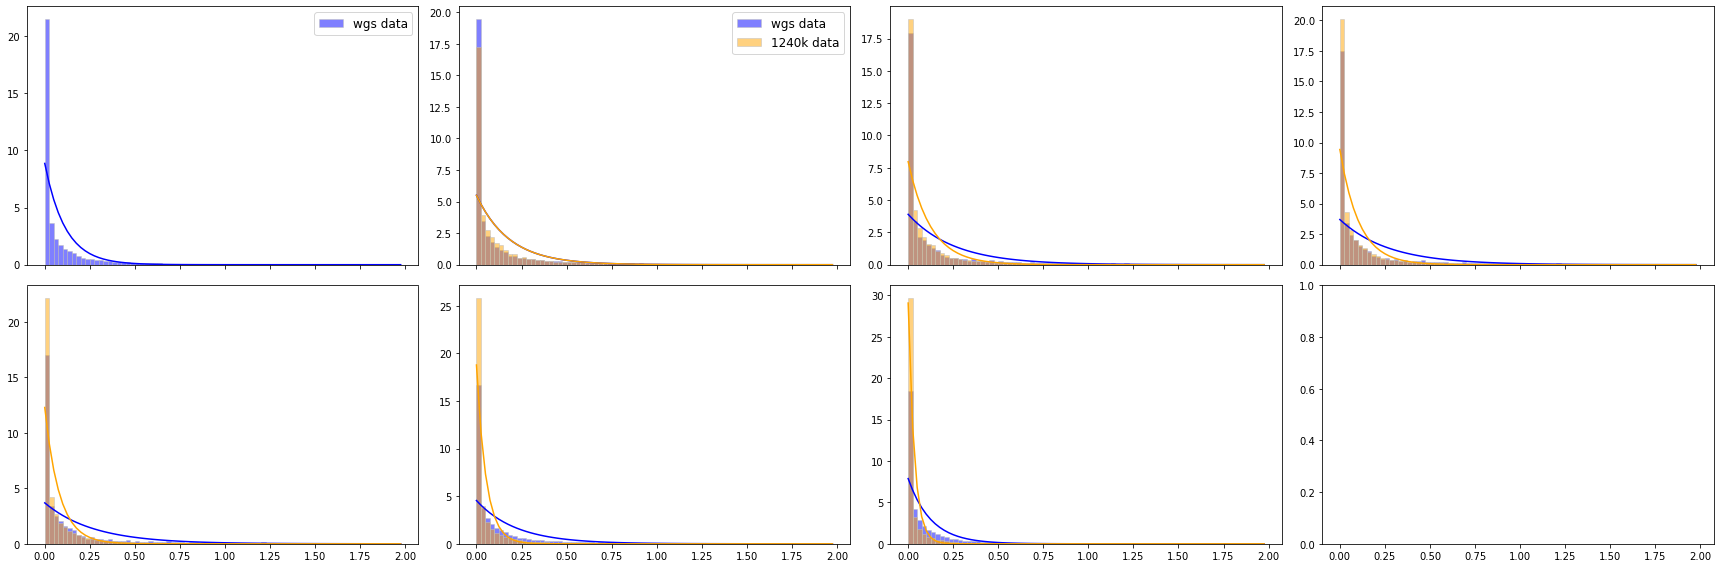

In [9]:
# wgs
import matplotlib.pyplot as plt
from scipy.stats import expon

covs = ['cov5', 'cov2', 'cov1', 'cov3over4', 'cov1over2', 'cov1over4', 'cov1over10']
fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(24, 8), tight_layout=True)
bins = np.arange(0,2,0.025)
for i, cov in enumerate(covs):
    row, col = i//4, i%4
    blocks = readDiffSwitchFileOneBatch(f'/mnt/archgen/users/yilei/IBDsim/downsample/wgs/I3949/{cov}', 'out.diff.switch.1kg')
    axs[row, col].hist(blocks, bins=bins, ec='silver', alpha=0.5, color='blue', density=True, label='wgs data')
    mu = np.mean(blocks)
    print(f'{cov}: {mu}')
    #print(f'{np.sum(blocks == 0.0)/len(blocks)}')
    pdf = expon.pdf(bins, loc=0, scale=mu)
    axs[row, col].plot(bins, pdf, color='blue')


# 1240k
for i, cov in enumerate(covs[1:]):
    i += 1
    row, col = i//4, i%4
    blocks = readDiffSwitchFileOneBatch(f'/mnt/archgen/users/yilei/IBDsim/downsample/1240k/I3949/{cov}', 'out.diff.switch.1kg')
    axs[row, col].hist(blocks, bins=bins, ec='silver', alpha=0.5, color='orange', density=True, label='1240k data')
    mu = np.mean(blocks)
    print(f'{cov}: {mu}')
    pdf = expon.pdf(bins, loc=0, scale=mu)
    axs[row, col].plot(bins, pdf, color='orange')


axs[0,0].legend(loc='upper right', fontsize='large')
axs[0,1].legend(loc='upper right', fontsize='large')
plt.savefig('test.png', dpi=300)


